In [11]:
%matplotlib inline
import numpy 
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

from matplotlib import animation
from IPython.display import HTML

вставить метод годунова

вставить градиенты и убедиться в работе

In [12]:
def get_flux(u_max, rho_max,rho):
    return u_max*rho*(1-rho/rho_max)

def Jac(u_max, rho_max,rho):
    return u_max*(1-2*rho/rho_max)

def rho_green_light(nx, rho_light):
    
    rho = numpy.arange(nx)*2./nx*rho_light
    rho[int((nx-1)/2):] = 0
    
    return rho

def rho_red_light(nx, rho_max, rho_in):
    
    rho = rho_max*numpy.ones(nx)
    rho[:int((nx-1)*3/4)] = rho_in
    
    return rho

In [13]:
def godunov_traffic(u_max, rho_max, rho_l, rho_r):
    u_l = Jac(u_max, rho_max, rho_l)
    u_r = Jac(u_max, rho_max, rho_r)
    
    if (u_l >= u_r):
        s = u_max*(1-(rho_r+rho_l)/rho_max)
        if s>0:
            rho_star = rho_l
        else:
            rho_star = rho_r
    else:
        if u_l >= 0:
            rho_star = rho_l
        if u_r < 0:
            rho_star = rho_r
        if (u_l < 0 and u_r > 0):
            rho_star = rho_max/2
    return get_flux(u_max, rho_max, rho_star)

In [14]:
#Basic initial condition parameters
#defining grid size, time steps, CFL condition, etc...
nx = 101
nt = 60
dx = 4.0/(nx-2)

rho_in = 5.
rho_max = 10.

V_max = 1.

x = numpy.linspace(0,4,nx-1)
rho = rho_red_light(nx-1, rho_max, rho_in)

In [15]:
def computeF(u_max, rho_max, rho):
    return u_max*rho*(1-rho/rho_max)

In [16]:
def animate(data):
    x = numpy.linspace(0,4,nx-1)
    y = data
    line.set_data(x,y)
    return line,

In [17]:
def godunov(rho, nt, dt, dx, rho_max, V_max):
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    
    #setup some temporary arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
  
    for t in range(1,nt):
        
        rho_plus[:-1] = rho[1:] # Can't do i+1/2 indices, so cell boundary
        rho_minus = rho.copy() # arrays at index i are at location i+1/2
        flux = 0.5 * (computeF(V_max, rho_max, rho_minus) + 
                      computeF(V_max, rho_max, rho_plus) + 
                      dx / dt * (rho_minus - rho_plus))
        rho_n[t,1:-1] = rho[1:-1] + dt/dx*(flux[:-2]-flux[1:-1])
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

In [18]:
sigma = 1.0
dt = sigma*dx/V_max

rho = rho_red_light(nx-1, rho_max, rho_in)      #make sure that u is set to our expected initial conditions
rho_n = godunov(rho, nt, dt, dx, rho_max, V_max)

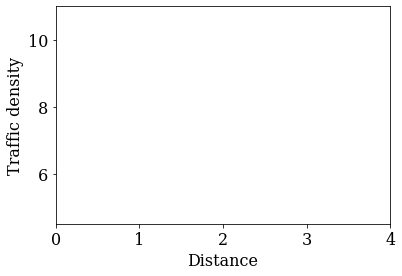

In [19]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

In [20]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())

## Muscl с годуновым (на транспортных потоках)

In [21]:
def minmod(e, dx):
    
    sigma = numpy.zeros_like(e)
    de_minus = numpy.ones_like(e)
    de_plus = numpy.ones_like(e)
    
    de_minus[1:] = (e[1:] - e[:-1])/dx
    de_plus[:-1] = (e[1:] - e[:-1])/dx
        
    # The following is inefficient but easy to read
    for i in range(1, len(e)-1):
        if (de_minus[i] * de_plus[i] < 0.0):
            sigma[i] = 0.0
        elif (numpy.abs(de_minus[i]) < numpy.abs(de_plus[i])):
            sigma[i] = de_minus[i]
        else:
            sigma[i] = de_plus[i]
            
    return sigma

In [22]:
def muscl(rho, nt, dt, dx, rho_max, V_max):

    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    
    #setup some temporary arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
    rho_star = numpy.zeros_like(rho)

    for t in range(1,nt):
               
        sigma = minmod(rho,dx) #calculate minmod slope

        #reconstruct values at cell boundaries
        rho_left = rho + sigma*dx/2.
        rho_right = rho - sigma*dx/2.
        
        #flux i = i + 1/2
        for i in range(len(rho)-1):
            flux[i] = godunov_traffic(V_max, rho_max, rho_left[i], rho_right[i+1])        
       
        #rk2 step 1
        rho_star[1:-1] = rho[1:-1] + dt/dx * (flux[:-2] - flux[1:-1])
        
        rho_star[0] = rho[0]
        rho_star[-1] = rho[-1]
        
        sigma = minmod(rho_star,dx) #calculate minmod slope
    
        #reconstruct values at cell boundaries
        rho_left = rho_star + sigma*dx/2.
        rho_right = rho_star - sigma*dx/2.
        
        for i in range(len(rho)-1):
            flux[i] = godunov_traffic(V_max, rho_max, rho_left[i], rho_right[i+1])
       
        rho_n[t,1:-1] = .5 * (rho[1:-1] + rho_star[1:-1] + dt/dx * (flux[:-2] - flux[1:-1]))
        
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

In [23]:
nx = 101
nt = 120
dx = 4.0/(nx-2)

V_max = 10
sigma = 1.
dt = sigma*dx/V_max

rho = rho_green_light(nx-1, rho_max)      #make sure that u is set to our expected initial conditions
rho_n_2 = muscl(rho, nt, dt, dx, rho_max, V_max)

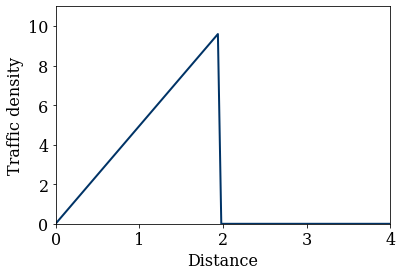

In [24]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(0,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n_2, interval=50)
HTML(anim.to_html5_video())